## Estimaciones de incertidumbre de los clasificadores

Otra parte útil de la interfaz scikit-learn de la que todavía no hemos hablado es la capacidad de los clasificadores para proporcionar estimaciones de incertidumbre de las predicciones. A menudo, no solo interesa qué clase predice un clasificador para un determinado punto de prueba, sino también qué tan cierto es que esta es la clase correcta.

En la práctica, los diferentes tipos de errores conducen a resultados muy diferentes en las aplicaciones del mundo real. Imagine una aplicación médica para detectar cáncer. Hacer una predicción  falsa positiva puede llevar a que el paciente se someta a pruebas adicionales, mientras que una predicción falsa negativa puede llevar a que no se trate una enfermedad grave.

Hay dos funciones diferentes en scikit-learn que se pueden usar para obtener estimaciones de incertidumbre de los clasificadores: `decision_function` y `predic_proba`. La mayoría (pero no todos) de los clasificadores tienen al menos uno de ellos, y muchos clasificadores tienen ambos. 


Veamos qué hacen estas dos funciones en un conjunto de datos bidimensional artificial, al construir un clasificador GradientBoostingClassifier, que tiene un método `decision_function` y un método `predict_proba`:


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(noise=0.25, factor=0.5, random_state=1)
# renombramos las clases "blue" y "red" 
y_nombrado = np.array(["blue", "red"])[y]


X_entrenamiento, X_prueba, y_entrenamiento_nombrado, y_prueba_nombrado, y_entrenamiento, y_prueba = \
train_test_split(X, y_nombrado, y, random_state=0)

# contruimos el modelo  gradient boosting
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_entrenamiento, y_entrenamiento_nombrado)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

### Función de decisión

En el caso de clasificación binaria, el valor de retorno de `decision_function` tiene la forma  de `(n_samples,)` y devuelve un número de coma flotante para cada muestra:

In [2]:
print("X_test dimension: {}".format(X_prueba.shape))
print("Dimension de la funcion de decision: {}".format(gbrt.decision_function(X_prueba).shape))

X_test dimension: (25, 2)
Dimension de la funcion de decision: (25,)


Este valor indica que tanto el modelo cree que un punto de datos pertenece a la clase "positiva", en este caso, la `clase 1`. Los valores positivos indican una preferencia por la clase positiva y los valores negativos indican una preferencia por "negativa" (otra) clase:

In [3]:
print("Funcion de decision:\n{}".format(gbrt.decision_function(X_prueba)[:6]))

Funcion de decision:
[ 4.13592629 -1.7016989  -3.95106099 -3.62599351  4.28986668  3.66166106]


Podemos recuperar la predicción mirando solo el signo de la función de decisión:


In [4]:
print("Funcion de decision con umbral:\n{}".format( gbrt.decision_function(X_prueba) > 0))
print("Predicciones:\n{}".format(gbrt.predict(X_prueba)))

Funcion de decision con umbral:
[ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
Predicciones:
['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


Para la clasificación binaria, la clase "negativa" es siempre la primera entrada del atributo `classes_` y la clase "positive" es la segunda entrada de `classes_`. Entonces, si quiere recuperar completamente la salida de `predict`, se necesita hacer uso del atributo `classes_`:

In [5]:
# convertimos los booleanos  True/False en 0 ay 1
mayor_cero = (gbrt.decision_function(X_prueba) > 0).astype(int)

# usamos 0 y 1 como indices en el atributo classes_
pred = gbrt.classes_[mayor_cero]

# pred es la misma salida que  gbrt.predict
print("pred es igual a gbrt.predict: {}".format(np.all(pred == gbrt.predict(X_prueba))))

pred es igual a gbrt.predict: True


El rango de `decision_function` puede ser arbitrario y depende de los datos y los parámetros del modelo:

In [7]:
funcion_decision = gbrt.decision_function(X_prueba)
print("Funcion de decision minima: {:.2f} maxima: {:.2f}".format(np.min(funcion_decision), 
                            np.max(funcion_decision)))

Funcion de decision minima: -7.69 maxima: 4.29


Esta escala arbitraria hace que el resultado de `decision_function` a menudo sea difícil de interpretar.

#### Ejemplo


In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import  colorConverter

def dibuja_dispersion_discreta(x1, x2, y=None, marcadores=None, s=10, ax=None,
                     etiquetas=None, relleno=.2, alfa=1, c=None, anchobordemarcador=None):
    """Adaptacion de la funcion matplotlib.pyplot.scatter a dibujar clases o  clusters"""
    
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unico_y = np.unique(y)

    if marcadores is None:
        marcadores= ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(marcadores) == 1:
        marcadores = marcadores * len(unico_y)

    if etiquetas is None:
        etiquetas = unico_y

    # lineas en el sentido de matplotlib
    lineas = []

    actual_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unico_y, actual_cycler())):
        mascara = y == yy
        # if c is ninguno, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # bordes claros para marcadores oscuros
        if np.mean(colorConverter.to_rgb(color)) < .4:
            colorbordemarcador = "grey"
        else:
            colorbordemarcador = "black"

        lineas.append(ax.plot(x1[mascara], x2[mascara], marcadores[i], markersize=s,
                             label=etiquetas[i], alpha=alfa, c=color,
                             markeredgewidth=anchobordemarcador,
                             markeredgecolor=colorbordemarcador)[0])

    if relleno != 0:
        pad1 = x1.std() * relleno
        pad2 = x2.std() * relleno
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lineas

Utilizamos funciones definidas anteriormente.

In [12]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cm2 = ListedColormap(['#0000aa', '#ff2020'])
cdict = {'red': [(0.0, 0.0, cm2(0)[0]),
                 (1.0, cm2(1)[0], 1.0)],

         'green': [(0.0, 0.0, cm2(0)[1]),
                   (1.0, cm2(1)[1], 1.0)],

         'blue': [(0.0, 0.0, cm2(0)[2]),
                  (1.0, cm2(1)[2], 1.0)]}

ReBl = LinearSegmentedColormap("ReBl", cdict)

def dibuja_separador_2d(clasificador, X, relleno=False, ax=None, eps=None, alfa=1,
                      cm=cm2, ancholinea=None, umbral=None,
                      estilolinea="solid"):

    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        valor_decision = clasificador.decision_function(X_grid)
        niveles = [0] if umbral is None else [umbral]
        niveles_f = [valor_decision.min()] + niveles + [valor_decision.max()]
    except AttributeError:
        # No funciones de decision
        valor_decision = clasificador.predict_proba(X_grid)[:, 1]
        niveles = [.5] if umbral is None else [umbral]
        niveles_f = [0] + niveles + [1]
    if relleno:
        ax.contourf(X1, X2, valor_decision.reshape(X1.shape),
                    levels=niveles_f, alpha=alfa, cmap=cm)
    else:
        ax.contour(X1, X2, valor_decision.reshape(X1.shape), levels=niveles,
                   colors="black", alpha=alfa, linewidths=ancholinea,
                   linestyles=estilolinea, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

Utilizamos esta función para dibujar ciertas puntuaciones el espacio de dos dimensiones.

In [16]:
def dibuja_2d_puntuaciones(clasificador, X, ax=None, eps=None, alfa=1, cm="viridis", funcion=None):
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    if funcion is None:
        funcion = getattr(clasificador,"decision_function",
                           getattr(clasificador, "predict_proba"))
    else:
        funcion = getattr(clasificador, funcion)
    valores_decision = funcion(X_grid)
    if valores_decision.ndim > 1 and valores_decision.shape[1] > 1:
        # predict_proba
        valores_decision = valores_decision[:, 1]
    grr = ax.imshow(valores_decision.reshape(X1.shape), extent=(x_min, x_max, y_min, y_max), aspect='auto',
                    origin='lower', alpha=alfa, cmap=cm)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    return grr

En el siguiente ejemplo, graficamos `decision_function` para todos los puntos en el plano 2D usando un código de color, junto a una visualización de la frontera de decisión. Mostramos puntos de entrenamiento como círculos y los datos de prueba como triángulos.

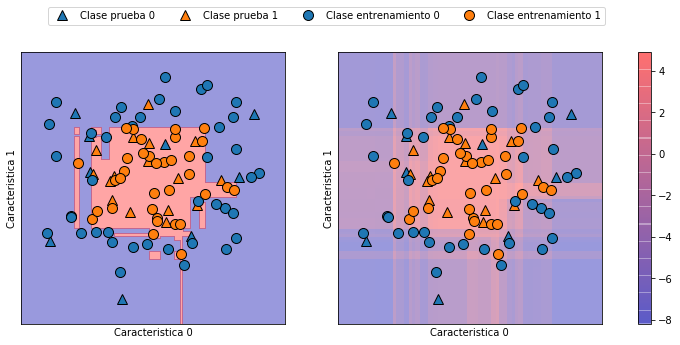

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
dibuja_separador_2d(gbrt, X, ax=axes[0], alfa=.4,relleno=True, cm=cm2)
imagen_puntuacion = dibuja_2d_puntuaciones(gbrt, X, ax=axes[1], alfa=.4, cm=ReBl)
# dibujamos los conjuntos de entrenamiento y prueba
for ax in axes:
    dibuja_dispersion_discreta(X_prueba[:, 0], X_prueba[:, 1], y_prueba, marcadores='^', ax=ax)
    dibuja_dispersion_discreta(X_entrenamiento[:, 0], X_entrenamiento[:, 1], y_entrenamiento,marcadores='o', ax=ax)
    
    ax.set_xlabel("Caracteristica 0")
    ax.set_ylabel("Caracteristica 1")
cbar = plt.colorbar(imagen_puntuacion, ax=axes.tolist())
axes[0].legend(["Clase prueba 0", "Clase prueba 1", "Clase entrenamiento 0",
                "Clase entrenamiento 1"], ncol=4, loc=(.1, 1.1))

La codificación no solo del resultado previsto sino también de cuán certero  es el clasificador, proporciona información adicional. Sin embargo, en esta visualización, es difícil distinguir la frontera entre las dos clases.

### Predicción de probabilidades

La salida de `predict_proba` es una probabilidad para cada clase  y a menudo se entiende más fácilmente que la salida de `decision_function`. Siempre tiene la forma de `(n_samples, 2)` para la clasificación binaria:

In [19]:
print("Dimension de probabilidades: {}".format(gbrt.predict_proba(X_prueba).shape))

Dimension de probabilidades: (25, 2)


La primera entrada en cada fila es la probabilidad estimada de la primera clase, y la segunda entrada es la probabilidad estimada de la segunda clase. Como es una probabilidad, la salida de predicción_proba siempre está entre 0 y 1, y la suma de las entradas para ambas clases es siempre 1:

In [20]:
# mostremos las primeras entradas de predict_proba

print("Probabilidades predichas:\n{}".format(gbrt.predict_proba(X_prueba[:6])))

Probabilidades predichas:
[[0.01573626 0.98426374]
 [0.84575649 0.15424351]
 [0.98112869 0.01887131]
 [0.97406775 0.02593225]
 [0.01352142 0.98647858]
 [0.02504637 0.97495363]]


Debido a que las probabilidades para las dos clases suman 1, exactamente una de las clases tendrá una certeza superior al 50%. Esa clase es la que se predice.

Se puede ver en el resultado anterior que el clasificador es relativamente cierto para la mayoría de los puntos. La medida que realmente refleja la incertidumbre en los datos depende del modelo y los parámetros.  Un modelo que está más ajustado tiende a hacer predicciones más seguras, incluso si pueden estar equivocadas. Un modelo con menos complejidad generalmente tiene más incertidumbre en sus predicciones. Un modelo se denomina calibrado si la incertidumbre informada coincide con lo correcto que es: en un modelo calibrado, una predicción hecha con una certeza del 70% sería correcta el 70% de las veces.

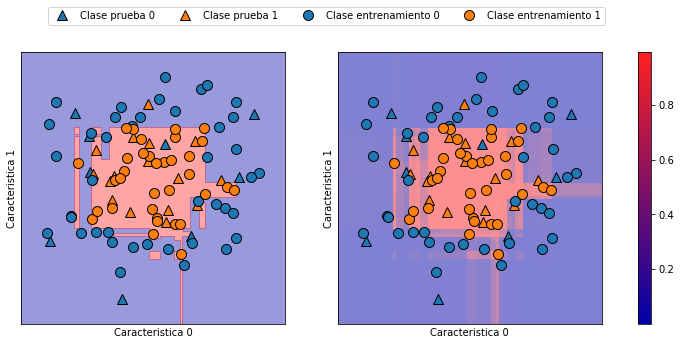

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
dibuja_separador_2d(gbrt, X, ax=axes[0], alfa=.4,relleno=True, cm=cm2)
imagen_puntuacion = dibuja_2d_puntuaciones(gbrt, X, ax=axes[1], alfa=.5, cm=ReBl, funcion='predict_proba')
# dibujamos los conjuntos de entrenamiento y prueba
for ax in axes:
    dibuja_dispersion_discreta(X_prueba[:, 0], X_prueba[:, 1], y_prueba, marcadores='^', ax=ax)
    dibuja_dispersion_discreta(X_entrenamiento[:, 0], X_entrenamiento[:, 1], y_entrenamiento,marcadores='o', ax=ax)
    
    ax.set_xlabel("Caracteristica 0")
    ax.set_ylabel("Caracteristica 1")
    

cbar = plt.colorbar(imagen_puntuacion, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Clase prueba 0", "Clase prueba 1", "Clase entrenamiento 0",
                "Clase entrenamiento 1"], ncol=4, loc=(.1, 1.1))

El [scikit-learn website](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) tiene una gran comparación de muchos modelos y cómo son sus estimaciones de incertidumbre.

### Incertidumbre en la clasificación multiclase

Los métodos `decision_function` y `predic_proba`  también funcionan en la configuración multiclase. Vamos a aplicarlos en el conjunto de datos Iris, que es un conjunto de datos de clasificación de tres clases:

In [23]:
from sklearn.datasets import load_iris
iris = load_iris()

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(iris.data, iris.target, random_state=42)
gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_entrenamiento, y_entrenamiento)

print("Dimension de la funcion de decision: {}".format(gbrt.decision_function(X_prueba).shape))

# mostramos las primeras entradas de la funcion de decision
print("Funcion de decision:\n{}".format(gbrt.decision_function(X_prueba)[:6, :]))

Dimension de la funcion de decision: (38, 3)
Funcion de decision:
[[-0.52931069  1.46560359 -0.50448467]
 [ 1.51154215 -0.49561142 -0.50310736]
 [-0.52379401 -0.4676268   1.51953786]
 [-0.52931069  1.46560359 -0.50448467]
 [-0.53107259  1.28190451  0.21510024]
 [ 1.51154215 -0.49561142 -0.50310736]]


En el caso multiclase, la `decision_function` tiene la forma `(n_samples, n_classes)` y cada columna proporciona un "puntaje de certeza" para cada clase, donde un puntaje grande significa que una clase es más probable y un puntaje pequeño significa que la clase es menos probable. 

Se pueden recuperar las predicciones de estos puntajes al encontrar la entrada máxima para cada punto de datos:

In [24]:
print("Argmax de una funcion de decision:\n{}".format( np.argmax(gbrt.decision_function(X_prueba), axis=1)))
print("Predicciones:\n{}".format(gbrt.predict(X_prueba)))

Argmax de una funcion de decision:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predicciones:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


La salida de `predict_proba` tiene la misma forma `(n_samples, n_classes)`. De nuevo, las probabilidades para las clases posibles para cada punto de datos suman 1:

In [25]:
# mostramos las primeras entradas de predict_proba
print("Probababilidades predecidas:\n{}".format(gbrt.predict_proba(X_prueba)[:6]))

# muestra que la suma  en las filas que suman 
print("Suma: {}".format(gbrt.predict_proba(X_prueba)[:6].sum(axis=1)))

Probababilidades predecidas:
[[0.10664722 0.7840248  0.10932798]
 [0.78880668 0.10599243 0.10520089]
 [0.10231173 0.10822274 0.78946553]
 [0.10664722 0.7840248  0.10932798]
 [0.10825347 0.66344934 0.22829719]
 [0.78880668 0.10599243 0.10520089]]
Suma: [1. 1. 1. 1. 1. 1.]


Nuevamente podemos recuperar las predicciones calculando el `argmax` de `predic_proba`:

In [26]:
print("Argmax de probabilidades predecidas:\n{}".format(np.argmax(gbrt.predict_proba(X_prueba), axis=1)))
print("Predicciones:\n{}".format(gbrt.predict(X_prueba)))

Argmax de probabilidades predecidas:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predicciones:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


Puede recuperar la predicción cuando hay `n_classes` de muchas columnas calculando el argumento `argmax` en las columnas. Hay que tener  cuidado, sin embargo, si las clases son cadenas o usa enteros pero no son consecutivos y comienzan desde 0.

Si se desea comparar los resultados obtenidos con `predict`, y los resultados obtenidos a través de `decision_function` o `predict_proba`, hay que asegurarse de usar el atributo `classes_` de el clasificador para obtener los nombres de clase reales:

In [27]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

# representamos cada objetivo por su nombre de clase en el conjunto de datos del iris
nombre_objetivo = iris.target_names[y_entrenamiento]
logreg.fit(X_entrenamiento, nombre_objetivo)

print("clases unicas en datos de entrenamiento: {}".format(logreg.classes_))
print("predicciones: {}".format(logreg.predict(X_prueba)[:10]))

argmax_funcion_decision = np.argmax(logreg.decision_function(X_prueba), axis=1)
print("argmax de funciones de decision: {}".format(argmax_funcion_decision[:10]))
print("argmax combinado con classes_: {}".format(logreg.classes_[argmax_funcion_decision][:10]))

clases unicas en datos de entrenamiento: ['setosa' 'versicolor' 'virginica']
predicciones: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
argmax de funciones de decision: [1 0 2 1 1 0 1 2 1 1]
argmax combinado con classes_: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
